In [82]:
# Imports
import os
import requests
import numpy as np
import matplotlib.pyplot as plt

import time
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
import numpy as np
import pandas as pd
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)


Running on device: CUDA


In [2]:
# Laod datasets from pytorch
# Transformations
transformations = transforms.Compose([transforms.ToTensor()])

train_set = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transformations
)
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)

test_set = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transformations
)
test_loader = DataLoader(test_set, batch_size=256, shuffle=True, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 122517530.08it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 107389799.49it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43513413.47it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19927331.35it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



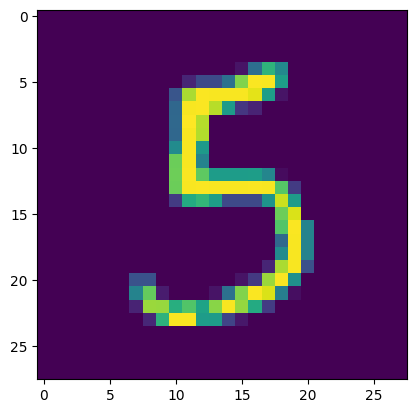

In [3]:
# Show image

iterator = iter(train_loader)
images, labels = next(iterator)
image = images[0].permute(1, 2, 0)
plt.imshow(image)

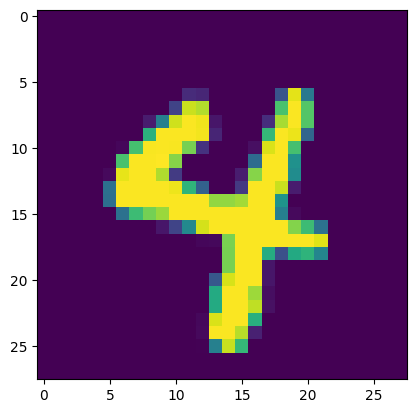

In [4]:
# Show image

iterator = iter(test_loader)
images, labels = next(iterator)
image = images[0].permute(1, 2, 0)
plt.imshow(image)

In [5]:
len(test_set)

10000

In [27]:
# Defining CNN
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, padding=1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, padding=1),
        )

        self.fc = nn.Sequential(
            nn.Linear(32*8*8, 500),
            nn.ReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(500, 100),
            nn.ReLU(),
        )
        self.fc_3d = nn.Linear(100, 3)
        self.relu_3d = nn.ReLU()
        self.fc_final = nn.Linear(3, 10)
        self.relu_final = nn.ReLU()
        self.sftmx = nn.Softmax(dim=1)


    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch

        x = self.fc(x)
        x = self.fc_3d(x)
        x = self.relu_3d(x)
        x = self.relu_final(self.fc_final(x))
        x = self.sftmx(x)
        return x


net = Net()

In [83]:
net

Net(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=2048, out_features=500, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=500, out_features=100, bias=True)
    (4): ReLU()
  )
  (fc_3d): Linear(in_features=100, out_features=3, bias=True)
  (relu_3d): Re

In [28]:
net = net.to(DEVICE)

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [30]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for i, (inputs, targets) in enumerate(loader, 0):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total

In [31]:
# Training model
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    net.train()
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    running_loss_test = 0.0
    net.eval()
    for j, data in enumerate(test_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # print statistics
        running_loss_test += loss.item()
    print(f"Total train loss on epoch {epoch} is: {running_loss / i}")
    print(f"Total test loss on epoch {epoch} is: {running_loss_test / j}")
    print(f"Accuracy on test set:  {100.0 * accuracy(net, test_loader):0.1f}%")
    print("------------------------------------------------------------------")

print('Finished Training')

Total train loss on epoch 0 is: 1.8347458044687908
Total test loss on epoch 0 is: 1.7707608357453957
Accuracy on test set:  69.5%
------------------------------------------------------------------
Total train loss on epoch 1 is: 1.708977113931607
Total test loss on epoch 1 is: 1.7306595184864142
Accuracy on test set:  78.9%
------------------------------------------------------------------
Total train loss on epoch 2 is: 1.6790137082083612
Total test loss on epoch 2 is: 1.706950734823178
Accuracy on test set:  79.2%
------------------------------------------------------------------
Total train loss on epoch 3 is: 1.6568728817833795
Total test loss on epoch 3 is: 1.686606465241848
Accuracy on test set:  79.2%
------------------------------------------------------------------
Total train loss on epoch 4 is: 1.6481480562788808
Total test loss on epoch 4 is: 1.680523951848348
Accuracy on test set:  79.8%
------------------------------------------------------------------
Total train loss on

In [32]:
net.eval()
print(f"Train set accuracy: {100.0 * accuracy(net, train_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(net, test_loader):0.1f}%")

Train set accuracy: 89.5%
Test set accuracy: 89.3%


In [33]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = torch.flatten(output.detach(), 1)
    return hook

net.fc_3d.register_forward_hook(get_activation('xyz'))

In [66]:
df_dict = {
    "label": [],
    "x": [],
    "y": [],
    "z": [],
    "train": []
}

In [67]:
net = net.to("cpu")

In [84]:
total_num = 0
for i, batch in enumerate(train_loader, 0):
  images, labels = batch
  for image, label in zip(images, labels):
    net(image.unsqueeze(0))
    total_num += 1

    df_dict["label"].append(label)
    df_dict["x"].append(activation['xyz'][0][0].item())
    df_dict["y"].append(activation['xyz'][0][1].item())
    df_dict["z"].append(activation['xyz'][0][2].item())
    df_dict["train"].append("Тренувальний набір")

In [69]:
total_num = 0
for i, batch in enumerate(test_loader, 0):
  images, labels = batch
  for image, label in zip(images, labels):
    net(image.unsqueeze(0))
    total_num += 1

    df_dict["label"].append(label)
    df_dict["x"].append(activation['xyz'][0][0].item())
    df_dict["y"].append(activation['xyz'][0][1].item())
    df_dict["z"].append(activation['xyz'][0][2].item())
    df_dict["train"].append("Тестовий набір")

  if total_num > 10000:
    print("break")
    break

In [85]:
df = pd.DataFrame.from_dict(df_dict)

In [86]:
df

label           x           y           z               train
0      tensor(4)  -27.513109   80.606873  131.686737  Тренувальний набір
1      tensor(7)  110.702660   99.963974   15.354603  Тренувальний набір
2      tensor(2)   98.478104   -0.017138    3.064018  Тренувальний набір
3      tensor(8)  -48.494843  -41.697426   96.966049  Тренувальний набір
4      tensor(6)   86.602158  -11.919329  147.076981  Тренувальний набір
...          ...         ...         ...         ...                 ...
79995  tensor(9)   32.075260  186.182648   89.944435  Тренувальний набір
79996  tensor(6)   79.658676  -12.261014  132.661850  Тренувальний набір
79997  tensor(5)  -18.946661   33.016514  -30.881523  Тренувальний набір
79998  tensor(5)  -27.217701   56.904831  -45.672939  Тренувальний набір
79999  tensor(6)   62.307777   -9.301579  101.758011  Тренувальний набір

[80000 rows x 5 columns]

In [87]:
train_df = df.where(df['train'] == "Тренувальний набір").dropna()
train_df.describe()

x             y             z
count  70000.000000  70000.000000  70000.000000
mean      31.457263     54.131809     54.870506
std       55.781178     82.319311     68.778666
min     -125.280853   -317.056366   -746.536926
25%      -21.355165    -11.273617    -17.708714
50%       37.807636     52.407372     81.474060
75%       75.700380     89.550289    109.949587
max     1099.186401   1598.829346   1464.645142

In [88]:
test_df = df.where(df['train'] == "Тестовий набір").dropna()
test_df.describe()

x             y             z
count  10000.000000  10000.000000  10000.000000
mean      31.322248     53.954998     54.508039
std       55.673936     81.990988     68.810929
min     -105.867775   -219.417694   -489.886169
25%      -21.245718    -11.253665    -17.899935
50%       37.430254     52.945059     81.370987
75%       76.048676     89.719898    110.056583
max      750.186646   1205.724609    375.534607

In [89]:
import plotly.express as px
fig = px.scatter_3d(df, x='x', y='y', z='z', color='train')

fig.show()